# Environment Setup - Rabail's Part

### Required Imports ###
1. chess: The python-chess library. It handles the basic chess board logic such as legal moves, checkmate, etc.
2. numpy: The numerical computing library. It has been used for the tensors representing the chess board.
3. AECEnv: The Agent Environment Cycle. It builds the environment to handle the cycle of agents' turn sequence.
4. AgentSelector: A utitlity which manages the turns of the agents.
5. spaces: It is a gym-style API used to define action and observation spaces (what agents can do and observe).
6. gym: It has been used for the general reinforcement learning compatibility.

In [ ]:
!pip install python-chess
!pip install pettingzoo
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 65.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=79db086285a301ea3533343ca0724fc1dd8d6f4de7640d04ad94c9b78cff2617
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 29.3 MB/s eta 0:00:00


In [ ]:
import chess
import numpy as np
from pettingzoo import AECEnv
from pettingzoo.utils.agent_selector import AgentSelector
from gymnasium import spaces
import gym
import random

### Chess Environment Class ###
This defines the basic chess environment. The environment inherits from AECEnv, a part of the pettingzoo framework, for the multiagent interactions.
- The "metadata" specifies environment settings.
- The "init(self)" constructor method that initializes the environment.
- The "reset()" resets the environment for a new game.
- The "observe()" returns the current board state in tensor format which is supposed to be used by the agent for the observation.
- The "board_to_tensor()" converts the board to a tensor.
- The "step()" handles the agent's action, checks for the end of game and returns the state.
- The "render()" print the current board state.

In [ ]:
from pettingzoo import AECEnv
from gymnasium import spaces
import chess
import numpy as np
import random
from pettingzoo.utils.agent_selector import agent_selector

class ChessEnvironment(AECEnv):
    metadata = {'render_modes': ['human'], 'name': "Chess-v0", 'is_parallelizable': True}

    def __init__(self, render_mode=None):
        super().__init__()
        self.render_mode = render_mode
        self.board = chess.Board()
        self.agents = ["w", "b"]
        self.possible_agents = self.agents[:]
        self.current_agent_index = 0
        self.current_agent = self.agents[self.current_agent_index]
        self.agent_selection = self.current_agent
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}

        self._action_space = spaces.Discrete(4672)
        self._observation_space = spaces.Box(low=0, high=1, shape=(8, 8, 12), dtype=np.int8)

    def action_space(self, agent):
        return self._action_space

    def observation_space(self, agent):
        return self._observation_space

    def reset(self, seed=None, options=None):
        self.agents = ["w", "b"]
        self.board.reset()
        self.current_agent_index = 0
        self.current_agent = self.agents[self.current_agent_index]
        self.agent_selection = self.current_agent
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.agent_selector = agent_selector(self.agents)
        self.agent_selection = self.agent_selector.next()
        self._game_over_pending = False  # Initialize the game over flag

    def observe(self, agent):
        return self._board_to_tensor()

    def _board_to_tensor(self):
        piece_map = self.board.piece_map()
        tensor = np.zeros((8, 8, 12), dtype=np.int8)

        for square, piece in piece_map.items():
            row = 7 - (square // 8)
            col = square % 8
            piece_type = piece.piece_type - 1
            color_offset = 0 if piece.color == chess.WHITE else 6
            tensor[row, col, piece_type + color_offset] = 1

        return tensor

    def step(self, action):
        agent = self.agent_selection
        print("Agent:", agent)
        print("Action:", action)

        if self.terminations[agent] or self.truncations[agent]:
            self._was_game_over = self._game_over_pending
            self.agent_selection = self.agent_selector.next()
            return

        # Get all legal moves
        legal_moves = list(self.board.legal_moves)
        print("Legal moves:", legal_moves)

        # Ensure the action is within legal moves
        if 0 <= action < len(legal_moves):
            move = legal_moves[action]
            print("Action mapping:", move)  # what the action index maps to
            self.board.push(move)
        else:
            # Invalid move (penalize)
            self.rewards[agent] = -1
            other_agent = [a for a in self.agents if a != agent][0]
            self.rewards[other_agent] = 1

            # MARK game as pending: don't terminate yet!
            self._game_over_pending = True
            # Optionally store result for later

            # Advance agent cycle
            self.current_agent_index = 1 - self.current_agent_index
            self.current_agent = self.agents[self.current_agent_index]
            self.agent_selection = self.current_agent
            return self.observe(self.current_agent), self.rewards[self.current_agent], self.terminations[self.current_agent], self.truncations[self.current_agent], self.infos[self.current_agent]

        # Game over detection (bad move or checkmate/stalemate)
        game_over = False
        if self.board.is_game_over():
            result = self.board.result()
            if result == "1-0":
                self.rewards = {"w": 1, "b": -1}
            elif result == "0-1":
                self.rewards = {"w": -1, "b": 1}
            elif result == "1/2-1/2":  # Draw condition
                self.rewards = {"w": 0, "b": 0}
            game_over = True

        # Don't mark terminate/truncate yet! (this is the pending part)
        if game_over:
            self._game_over_pending = True
            # Optionally store rewards here, not in self.rewards yet
        else:
            # Normal transitions for an alive game
            self.rewards = {agent: 0 for agent in self.agents}
            self.terminations = {agent: False for agent in self.agents}
            self.truncations = {agent: False for agent in self.agents}

            self.current_agent_index = 1 - self.current_agent_index
            self.current_agent = self.agents[self.current_agent_index]
            self.agent_selection = self.current_agent  # Set the current agent for the next step

        # -- At the end of the cycle (after both agents have acted) --
        if self._game_over_pending and self.agent_selection == self.agents[0]:
            # End of cycle: now both agents can be terminated cleanly
            self.terminations = {agent: True for agent in self.agents}
            self.truncations = {agent: False for agent in self.agents}
            self._game_over_pending = False  # Reset the flag for the next cycle

            if all(self.terminations[agent] or self.truncations[agent] for agent in self.agents):
                self.agents = []  # End game and clear agents

        # Ensure game state consistency
        if self.current_agent is None:
            return None, 0, True, False, {}  # Game over, no agent to act

        return self.observe(self.current_agent), self.rewards[self.current_agent], self.terminations[self.current_agent], self.truncations[self.current_agent], self.infos[self.current_agent]

    def render(self):
        print(self.board)

    def close(self):
        pass

In [ ]:
###MASKED STEP FUNCTION
import numpy as np
import chess
from pettingzoo import AECEnv
from gymnasium import spaces
from pettingzoo.utils.agent_selector import agent_selector


class ChessEnvironment(AECEnv):
    metadata = {'render_modes': ['human'], 'name': "Chess-v0", 'is_parallelizable': True}

    def __init__(self, render_mode=None):
        super().__init__()
        self.render_mode = render_mode
        self.board = chess.Board()
        self.agents = ["w", "b"]
        self.possible_agents = self.agents[:]
        self.current_agent_index = 0
        self.current_agent = self.agents[self.current_agent_index]
        self.agent_selection = self.current_agent
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}

        self._action_space = spaces.Discrete(4672)
        self._observation_space = spaces.Box(low=0, high=1, shape=(8, 8, 12), dtype=np.int8)

    def action_space(self, agent):
        return self._action_space

    def observation_space(self, agent):
        return self._observation_space

    def reset(self, seed=None, options=None):
        self.agents = ["w", "b"]
        self.board.reset()
        self.current_agent_index = 0
        self.current_agent = self.agents[self.current_agent_index]
        self.agent_selection = self.current_agent
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.agent_selector = agent_selector(self.agents)
        self.agent_selection = self.agent_selector.next()
        self._game_over_pending = False  # Initialize the game over flag

    def observe(self, agent):
        return self._board_to_tensor()

    def _board_to_tensor(self):
        piece_map = self.board.piece_map()
        tensor = np.zeros((8, 8, 12), dtype=np.int8)

        for square, piece in piece_map.items():
            row = 7 - (square // 8)
            col = square % 8
            piece_type = piece.piece_type - 1
            color_offset = 0 if piece.color == chess.WHITE else 6
            tensor[row, col, piece_type + color_offset] = 1

        return tensor

    def _get_legal_move_mask(self):
        legal_moves = list(self.board.legal_moves)
        legal_move_mask = np.zeros(self._action_space.n, dtype=np.int8)

        # For each legal move, set the corresponding index in the mask to 1
        for move in legal_moves:
            move_index = self._move_to_index(move)
            legal_move_mask[move_index] = 1

        return legal_move_mask

    def _move_to_index(self, move):
        # Convert the move to an index in the action space
        # Assuming the action space is linear and sequentially ordered based on legal moves
        legal_moves = list(self.board.legal_moves)
        return legal_moves.index(move)

    def step(self, action):
        agent = self.agent_selection
        print("Agent:", agent)
        print("Action:", action)

        if self.terminations[agent] or self.truncations[agent]:
            self._was_game_over = self._game_over_pending
            self.agent_selection = self.agent_selector.next()
            return

        # Get legal move mask
        legal_move_mask = self._get_legal_move_mask()

        # Ensure the action is within the legal moves
        if legal_move_mask[action] == 1:
            move = self._index_to_move(action)
            print("Action mapping:", move)  # what the action index maps to
            self.board.push(move)
        else:
            # Invalid move (penalize)
            self.rewards[agent] = -1
            other_agent = [a for a in self.agents if a != agent][0]
            self.rewards[other_agent] = 1

            # MARK game as pending: don't terminate yet!
            self._game_over_pending = True
            # Optionally store result for later

            # Advance agent cycle
            self.current_agent_index = 1 - self.current_agent_index
            self.current_agent = self.agents[self.current_agent_index]
            self.agent_selection = self.current_agent
            return self.observe(self.current_agent), self.rewards[self.current_agent], self.terminations[self.current_agent], self.truncations[self.current_agent], self.infos[self.current_agent]

        # Game over detection (bad move or checkmate/stalemate)
        game_over = False
        if self.board.is_game_over():
            result = self.board.result()
            if result == "1-0":
                self.rewards = {"w": 1, "b": -1}
            elif result == "0-1":
                self.rewards = {"w": -1, "b": 1}
            elif result == "1/2-1/2":  # Draw condition
                self.rewards = {"w": 0, "b": 0}
            game_over = True

        # Don't mark terminate/truncate yet! (this is the pending part)
        if game_over:
            self._game_over_pending = True
        else:
            # Normal transitions for an alive game
            self.rewards = {agent: 0 for agent in self.agents}
            self.terminations = {agent: False for agent in self.agents}
            self.truncations = {agent: False for agent in self.agents}

            self.current_agent_index = 1 - self.current_agent_index
            self.current_agent = self.agents[self.current_agent_index]
            self.agent_selection = self.current_agent  # Set the current agent for the next step

        # -- At the end of the cycle (after both agents have acted) --
        if self._game_over_pending and self.agent_selection == self.agents[0]:
            # End of cycle: now both agents can be terminated cleanly
            self.terminations = {agent: True for agent in self.agents}
            self.truncations = {agent: False for agent in self.agents}
            self._game_over_pending = False  # Reset the flag for the next cycle

            if all(self.terminations[agent] or self.truncations[agent] for agent in self.agents):
                self.agents = []  # End game and clear agents

        # Ensure game state consistency
        if self.current_agent is None:
            return None, 0, True, False, {}  # Game over, no agent to act

        return self.observe(self.current_agent), self.rewards[self.current_agent], self.terminations[self.current_agent], self.truncations[self.current_agent], self.infos[self.current_agent]

    def _index_to_move(self, action_index):
        legal_moves = list(self.board.legal_moves)
        return legal_moves[action_index]

    def render(self):
        print(self.board)

    def close(self):
        pass

### USE THIS ENV FOR EVALUATION

In [ ]:
### CUMULATIVE REWARDS
import numpy as np
import chess
from pettingzoo import AECEnv
from gymnasium import spaces
from pettingzoo.utils.agent_selector import agent_selector


class ChessEnvironment(AECEnv):
    metadata = {'render_modes': ['human'], 'name': "Chess-v0", 'is_parallelizable': True}

    def __init__(self, render_mode=None):
        super().__init__()
        self.render_mode = render_mode
        self.board = chess.Board()
        self.agents = ["w", "b"]
        self.possible_agents = self.agents[:]
        self.current_agent_index = 0
        self.current_agent = self.agents[self.current_agent_index]
        self.agent_selection = self.current_agent
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}

        self._action_space = spaces.Discrete(4672)
        self._observation_space = spaces.Box(low=0, high=1, shape=(8, 8, 12), dtype=np.int8)

    def action_space(self, agent):
        return self._action_space

    def observation_space(self, agent):
        return self._observation_space

    def reset(self, seed=None, options=None):
        self.agents = ["w", "b"]
        self.board.reset()
        self.current_agent_index = 0
        self.current_agent = self.agents[self.current_agent_index]
        self.agent_selection = self.current_agent
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.agent_selector = agent_selector(self.agents)
        self.agent_selection = self.agent_selector.next()
        self._game_over_pending = False  # Initialize the game over flag

    def observe(self, agent):
        return self._board_to_tensor()

    def _board_to_tensor(self):
        piece_map = self.board.piece_map()
        tensor = np.zeros((8, 8, 12), dtype=np.int8)

        for square, piece in piece_map.items():
            row = 7 - (square // 8)
            col = square % 8
            piece_type = piece.piece_type - 1
            color_offset = 0 if piece.color == chess.WHITE else 6
            tensor[row, col, piece_type + color_offset] = 1

        return tensor

    def _get_legal_move_mask(self):
        legal_moves = list(self.board.legal_moves)
        legal_move_mask = np.zeros(self._action_space.n, dtype=np.int8)

        # For each legal move, set the corresponding index in the mask to 1
        for move in legal_moves:
            move_index = self._move_to_index(move)
            legal_move_mask[move_index] = 1

        return legal_move_mask

    def _move_to_index(self, move):
        # Convert the move to an index in the action space
        # Assuming the action space is linear and sequentially ordered based on legal moves
        legal_moves = list(self.board.legal_moves)
        return legal_moves.index(move)

    def step(self, action):
      agent = self.agent_selection
      print("Agent:", agent)
      print("Action:", action)

      if self.terminations[agent] or self.truncations[agent]:
          self._was_game_over = self._game_over_pending
          self.agent_selection = self.agent_selector.next()
          return

      # Get legal move mask
      legal_move_mask = self._get_legal_move_mask()

      # Ensure the action is within the legal moves
      if legal_move_mask[action] == 1:
          move = self._index_to_move(action)
          print("Action mapping:", move)  # what the action index maps to
          self.board.push(move)
      else:
          # Invalid move (penalize)
          self.rewards[agent] = -1
          other_agent = [a for a in self.agents if a != agent][0]
          self.rewards[other_agent] = 1

          # Update cumulative rewards
          self._cumulative_rewards[agent] += self.rewards[agent]
          self._cumulative_rewards[other_agent] += self.rewards[other_agent]

          # MARK game as pending: don't terminate yet!
          self._game_over_pending = True
          # Optionally store result for later

          # Advance agent cycle
          self.current_agent_index = 1 - self.current_agent_index
          self.current_agent = self.agents[self.current_agent_index]
          self.agent_selection = self.current_agent
          return self.observe(self.current_agent), self.rewards[self.current_agent], self.terminations[self.current_agent], self.truncations[self.current_agent], self.infos[self.current_agent]

      # Game over detection (bad move or checkmate/stalemate)
      game_over = False
      if self.board.is_game_over():
          result = self.board.result()
          if result == "1-0":
              self.rewards = {"w": 1, "b": -1}
          elif result == "0-1":
              self.rewards = {"w": -1, "b": 1}
          elif result == "1/2-1/2":  # Draw condition
              self.rewards = {"w": 0, "b": 0}
          game_over = True

      # Update cumulative rewards
      if game_over:
          self._cumulative_rewards["w"] += self.rewards["w"]
          self._cumulative_rewards["b"] += self.rewards["b"]

      # Don't mark terminate/truncate yet! (this is the pending part)
      if game_over:
          self._game_over_pending = True
      else:
          # Normal transitions for an alive game
          self.rewards = {agent: 0 for agent in self.agents}
          self.terminations = {agent: False for agent in self.agents}
          self.truncations = {agent: False for agent in self.agents}

          self.current_agent_index = 1 - self.current_agent_index
          self.current_agent = self.agents[self.current_agent_index]
          self.agent_selection = self.current_agent  # Set the current agent for the next step

      # -- At the end of the cycle (after both agents have acted) --
      if self._game_over_pending and self.agent_selection == self.agents[0]:
          # End of cycle: now both agents can be terminated cleanly
          self.terminations = {agent: True for agent in self.agents}
          self.truncations = {agent: False for agent in self.agents}
          self._game_over_pending = False  # Reset the flag for the next cycle

          if all(self.terminations[agent] or self.truncations[agent] for agent in self.agents):
              self.agents = []  # End game and clear agents

      # Ensure game state consistency
      if self.current_agent is None:
          return None, 0, True, False, {}  # Game over, no agent to act

      # Return the current observation, reward, termination, truncation, and info
      return self.observe(self.current_agent), self.rewards[self.current_agent], self.terminations[self.current_agent], self.truncations[self.current_agent], self.infos[self.current_agent]

    def _index_to_move(self, action_index):
        legal_moves = list(self.board.legal_moves)
        return legal_moves[action_index]

    def render(self):
        print(self.board)

    def close(self):
        pass


In [ ]:
# ### RENDER BOARD
# import numpy as np
# import chess
# from pettingzoo import AECEnv
# from gymnasium import spaces
# from pettingzoo.utils.agent_selector import agent_selector


# class ChessEnvironment(AECEnv):
#     metadata = {'render_modes': ['human'], 'name': "Chess-v0", 'is_parallelizable': True}

#     def __init__(self, render_mode=None):
#         super().__init__()
#         self.render_mode = render_mode
#         self.board = chess.Board()
#         self.agents = ["w", "b"]
#         self.possible_agents = self.agents[:]
#         self.current_agent_index = 0
#         self.current_agent = self.agents[self.current_agent_index]
#         self.agent_selection = self.current_agent
#         self._cumulative_rewards = {agent: 0 for agent in self.agents}
#         self.rewards = {agent: 0 for agent in self.agents}
#         self.terminations = {agent: False for agent in self.agents}
#         self.truncations = {agent: False for agent in self.agents}
#         self.infos = {agent: {} for agent in self.agents}

#         self._action_space = spaces.Discrete(4672)
#         self._observation_space = spaces.Box(low=0, high=1, shape=(8, 8, 12), dtype=np.int8)

#     def action_space(self, agent):
#         return self._action_space

#     def observation_space(self, agent):
#         return self._observation_space

#     def reset(self, seed=None, options=None):
#         self.agents = ["w", "b"]
#         self.board.reset()
#         self.current_agent_index = 0
#         self.current_agent = self.agents[self.current_agent_index]
#         self.agent_selection = self.current_agent
#         self._cumulative_rewards = {agent: 0 for agent in self.agents}
#         self.rewards = {agent: 0 for agent in self.agents}
#         self.terminations = {agent: False for agent in self.agents}
#         self.truncations = {agent: False for agent in self.agents}
#         self.infos = {agent: {} for agent in self.agents}
#         self.agent_selector = agent_selector(self.agents)
#         self.agent_selection = self.agent_selector.next()
#         self._game_over_pending = False  # Initialize the game over flag

#     def observe(self, agent):
#         return self._board_to_tensor()

#     def _board_to_tensor(self):
#         piece_map = self.board.piece_map()
#         tensor = np.zeros((8, 8, 12), dtype=np.int8)

#         for square, piece in piece_map.items():
#             row = 7 - (square // 8)
#             col = square % 8
#             piece_type = piece.piece_type - 1
#             color_offset = 0 if piece.color == chess.WHITE else 6
#             tensor[row, col, piece_type + color_offset] = 1

#         return tensor

#     def _get_legal_move_mask(self):
#         legal_moves = list(self.board.legal_moves)
#         legal_move_mask = np.zeros(self._action_space.n, dtype=np.int8)

#         # For each legal move, set the corresponding index in the mask to 1
#         for move in legal_moves:
#             move_index = self._move_to_index(move)
#             legal_move_mask[move_index] = 1

#         return legal_move_mask

#     def _move_to_index(self, move):
#         # Convert the move to an index in the action space
#         # Assuming the action space is linear and sequentially ordered based on legal moves
#         legal_moves = list(self.board.legal_moves)
#         return legal_moves.index(move)

#     def step(self, action):
#       agent = self.agent_selection
#       print("Agent:", agent)
#       print("Action:", action)

#       if self.terminations[agent] or self.truncations[agent]:
#           self._was_game_over = self._game_over_pending
#           self.agent_selection = self.agent_selector.next()
#           return

#       # Get legal move mask
#       legal_move_mask = self._get_legal_move_mask()

#       # Ensure the action is within the legal moves
#       if legal_move_mask[action] == 1:
#           move = self._index_to_move(action)
#           print("Action mapping:", move)  # what the action index maps to
#           self.board.push(move)
#       else:
#           # Invalid move (penalize)
#           self.rewards[agent] = -1
#           other_agent = [a for a in self.agents if a != agent][0]
#           self.rewards[other_agent] = 1

#           # Update cumulative rewards
#           self._cumulative_rewards[agent] += self.rewards[agent]
#           self._cumulative_rewards[other_agent] += self.rewards[other_agent]

#           # MARK game as pending: don't terminate yet!
#           self._game_over_pending = True
#           # Optionally store result for later

#           # Advance agent cycle
#           self.current_agent_index = 1 - self.current_agent_index
#           self.current_agent = self.agents[self.current_agent_index]
#           self.agent_selection = self.current_agent

#           self.render()  # Show the board after the invalid move
#           return self.observe(self.current_agent), self.rewards[self.current_agent], self.terminations[self.current_agent], self.truncations[self.current_agent], self.infos[self.current_agent]

#       # Game over detection (bad move or checkmate/stalemate)
#       game_over = False
#       if self.board.is_game_over():
#           result = self.board.result()
#           if result == "1-0":
#               self.rewards = {"w": 1, "b": -1}
#               winner = "White wins!"
#           elif result == "0-1":
#               self.rewards = {"w": -1, "b": 1}
#               winner = "Black wins!"
#           elif result == "1/2-1/2":  # Draw condition
#               self.rewards = {"w": 0, "b": 0}
#               winner = "Draw!"
#           game_over = True

#       # Update cumulative rewards
#       if game_over:
#           self._cumulative_rewards["w"] += self.rewards["w"]
#           self._cumulative_rewards["b"] += self.rewards["b"]
#           # Print the winner and display the final board
#           print(winner)
#           self.render()  # Show the final board

#       # Don't mark terminate/truncate yet! (this is the pending part)
#       if game_over:
#           self._game_over_pending = True
#       else:
#           # Normal transitions for an alive game
#           self.rewards = {agent: 0 for agent in self.agents}
#           self.terminations = {agent: False for agent in self.agents}
#           self.truncations = {agent: False for agent in self.agents}

#           self.current_agent_index = 1 - self.current_agent_index
#           self.current_agent = self.agents[self.current_agent_index]
#           self.agent_selection = self.current_agent  # Set the current agent for the next step

#       # -- At the end of the cycle (after both agents have acted) --
#       if self._game_over_pending and self.agent_selection == self.agents[0]:
#           # End of cycle: now both agents can be terminated cleanly
#           self.terminations = {agent: True for agent in self.agents}
#           self.truncations = {agent: False for agent in self.agents}
#           self._game_over_pending = False  # Reset the flag for the next cycle

#           if all(self.terminations[agent] or self.truncations[agent] for agent in self.agents):
#               self.agents = []  # End game and clear agents

#       # Ensure game state consistency
#       if self.current_agent is None:
#           return None, 0, True, False, {}  # Game over, no agent to act

#       # Render the board after each step
#       self.render()

#       # Return the current observation, reward, termination, truncation, and info
#       return self.observe(self.current_agent), self.rewards[self.current_agent], self.terminations[self.current_agent], self.truncations[self.current_agent], self.infos[self.current_agent]

#     def _index_to_move(self, action_index):
#         legal_moves = list(self.board.legal_moves)
#         return legal_moves[action_index]

#     def render(self):
#         print(self.board)

#     def close(self):
#         pass


In [ ]:
env = ChessEnvironment()

In [ ]:
import random

# Reset the environment
env.reset()
env.render()
print()

# Play until the game is over
while env.agents:  # This checks if there are any agents left to play
    agent = env.agent_selection

    # If the agent is terminated or truncated, skip their turn
    if env.terminations[agent] or env.truncations[agent]:
        env.step(None)  # Continue to the next agent
    else:
        # Get all legal moves for the current agent
        legal_moves = list(env.board.legal_moves)

        # If there are no legal moves, skip the agent's turn
        if not legal_moves:
            print(f"No legal moves for {agent}, skipping turn.")
            env.step(None)
            continue

        # Select a random move for this agent (could be modified for AI)
        move_index = random.choice(range(len(legal_moves)))
        obs, reward, terminated, truncated, info = env.step(move_index)

        # Print the move made by the agent and render the board
        print(f"\nMove by {agent}: {legal_moves[move_index]}")
        env.render()

# Final game result
result = env.board.result()
print("\nGame Over!")
print("Result:", result)

if result == "1-0":
    print("White (w) wins")
elif result == "0-1":
    print("Black (b) wins")
else:
    print("Draw")

/usr/local/lib/python3.11/dist-packages/pettingzoo/utils/agent_selector.py:71: DeprecationWarning: agent_selector is deprecated, please use AgentSelector
  warn(


Streaming output truncated to the last 5000 lines.
. . . . p . p .
. n p . . . . r
. N . . . . K .
. . . . . . . .
Agent: b
Action: 32
Action mapping: g4g3

Move by b: g4g3
. n . R b B k .
r . p . . . . .
p . P . . . . .
. . . . . . . .
. . . . p . . .
. n p . . . p r
. N . . . . K .
. . . . . . . .
Agent: w
Action: 15
Action mapping: d8d2

Move by w: d8d2
. n . . b B k .
r . p . . . . .
p . P . . . . .
. . . . . . . .
. . . . p . . .
. n p . . . p r
. N . R . . K .
. . . . . . . .
Agent: b
Action: 30
Action mapping: c3c2

Move by b: c3c2
. n . . b B k .
r . p . . . . .
p . P . . . . .
. . . . . . . .
. . . . p . . .
. n . . . . p r
. N p R . . K .
. . . . . . . .
Agent: w
Action: 19
Action mapping: d2d1

Move by w: d2d1
. n . . b B k .
r . p . . . . .
p . P . . . . .
. . . . . . . .
. . . . p . . .
. n . . . . p r
. N p . . . K .
. . . R . . . .
Agent: b
Action: 30
Action mapping: a6a5

Move by b: a6a5
. n . . b B k .
r . p . . . . .
. . P . . . . .
p . . . . . . .
. . . . p . . .
. n

In [ ]:
print("Game over due to:")
print("Stalemate:", env.board.is_stalemate())
print("Repetition:", env.board.is_repetition())
print("50-move rule:", env.board.can_claim_fifty_moves())
print("Insufficient material:", env.board.is_insufficient_material())


Game over due to:
Stalemate: False
Repetition: False
50-move rule: False
Insufficient material: True


# MARL Algorithm Development - Vaneeza's Part

In [ ]:
!pip install stable-baselines3
!pip install sb3-contrib
!pip install supersuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib import RecurrentPPO

Stable-Baselines3 (SB3) doesn’t work natively with PettingZoo. So using SuperSuit to make the environment compatible. We can now use wrapped_env with any SB3 algorithm.

## PPO (Policy Gradient Method)


In [ ]:
from pettingzoo.utils.conversions import aec_to_parallel
import supersuit as ss
from stable_baselines3 import PPO

# Convert your custom AECEnv to a parallel env
parallel_env = aec_to_parallel(env)

# Apply wrappers directly to the PettingZoo env (before SB3 conversion)
parallel_env = ss.black_death_v3(parallel_env)
parallel_env = ss.dtype_v0(parallel_env, dtype='float32')

# convert to SB3-compatible format
vec_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
vec_env = ss.concat_vec_envs_v1(vec_env, num_vec_envs=1, num_cpus=1, base_class='stable_baselines3')

In [ ]:
model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=10000)

Using cuda device
Agent: w
Action: 3344
Agent: b
Action: 3365
Agent: w
Action: 936
Agent: b
Action: 2608
Agent: w
Action: 4256
Agent: b
Action: 1026
Agent: w
Action: 2232
Agent: b
Action: 3988
Agent: w
Action: 1164
Agent: b
Action: 4533
Agent: w
Action: 2030
Agent: b
Action: 2751
Agent: w
Action: 1913
Agent: b
Action: 3434
Agent: w
Action: 1632
Agent: b
Action: 1052
Agent: w
Action: 1845
Agent: b
Action: 2802
Agent: w
Action: 2371
Agent: b
Action: 290
Agent: w
Action: 3697
Agent: b
Action: 2882
Agent: w
Action: 571
Agent: b
Action: 4174
Agent: w
Action: 446
Agent: b
Action: 112
Agent: w
Action: 3868
Agent: b
Action: 1486
Agent: w
Action: 2070
Agent: b
Action: 3632
Agent: w
Action: 4434
Agent: b
Action: 1160
Agent: w
Action: 2907
Agent: b
Action: 1464
Agent: w
Action: 3322
Agent: b
Action: 382
Agent: w
Action: 152
Agent: b
Action: 399
Agent: w
Action: 1605
Agent: b
Action: 2246
Agent: w
Action: 1950
Agent: b
Action: 222
Agent: w
Action: 719
Agent: b
Action: 151
Agent: w
Action: 1530
Age

In [ ]:
model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device


/usr/local/lib/python3.11/dist-packages/pettingzoo/utils/agent_selector.py:71: DeprecationWarning: agent_selector is deprecated, please use AgentSelector
  warn(


-----------------------------
| time/              |      |
|    fps             | 1082 |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 4096 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 457          |
|    iterations           | 2            |
|    time_elapsed         | 17           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0059417863 |
|    clip_fraction        | 0.0679       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.45        |
|    explained_variance   | 4.17e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0254      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.026       |
|    value_loss           | 0.00463      |
------------------------------------------
----------------

In [ ]:
model.save("ppo_chess_model")

## DQN Model

In [ ]:
from pettingzoo.utils.conversions import aec_to_parallel
import supersuit as ss
from stable_baselines3 import PPO

# Convert your custom AECEnv to a parallel env
parallel_env = aec_to_parallel(env)

# Apply wrappers directly to the PettingZoo env (before SB3 conversion)
parallel_env = ss.black_death_v3(parallel_env)
parallel_env = ss.dtype_v0(parallel_env, dtype='float32')

# convert to SB3-compatible format
vec_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
vec_env = ss.concat_vec_envs_v1(vec_env, num_vec_envs=1, num_cpus=1, base_class='stable_baselines3')

from stable_baselines3 import DQN
#env = ChessEnvironment()

# Define the DQN agent for the white and black players
dqn_model_white = DQN('MlpPolicy', vec_env, verbose=1, buffer_size=50000, exploration_fraction=0.1, exploration_final_eps=0.01)
dqn_model_black = DQN('MlpPolicy', vec_env, verbose=1, buffer_size=50000, exploration_fraction=0.1, exploration_final_eps=0.01)

dqn_model_white.learn(total_timesteps=10000)
dqn_model_black.learn(total_timesteps=10000)

Using cuda device
Using cuda device
Agent: w
Action: 556
Agent: b
Action: 4569
Agent: w
Action: 2223
Agent: b
Action: 3878
Agent: w
Action: 4569
Agent: b
Action: 1243
Agent: w
Action: 3655
Agent: b
Action: 3226
Agent: w
Action: 1277
Agent: b
Action: 4303
Agent: w
Action: 4150
Agent: b
Action: 1749
Agent: w
Action: 4062
Agent: b
Action: 109
Agent: w
Action: 4571
Agent: b
Action: 2407
Agent: w
Action: 2346
Agent: b
Action: 1074
Agent: w
Action: 4636
Agent: b
Action: 3543
Agent: w
Action: 2873
Agent: b
Action: 34
Agent: w
Action: 775
Agent: b
Action: 3083
Agent: w
Action: 1107
Agent: b
Action: 154
Agent: w
Action: 4329
Agent: b
Action: 1272
Agent: w
Action: 4102
Agent: b
Action: 3572
Agent: w
Action: 4281
Agent: b
Action: 3492
Agent: w
Action: 3544
Agent: b
Action: 4061
Agent: w
Action: 3439
Agent: b
Action: 4445
Agent: w
Action: 3127
Agent: b
Action: 3348
Agent: w
Action: 694
Agent: b
Action: 2180
Agent: w
Action: 1738
Agent: b
Action: 2015
Agent: w
Action: 2077
Agent: b
Action: 4057
Age

In [ ]:
# Save the trained models
dqn_model_white.save("dqn_model_white")
dqn_model_black.save("dqn_model_black")

## Evaluate

### PPO Agent Evaluation

In [ ]:
from pettingzoo.utils import AECEnv
import numpy as np

def evaluate_marl_agents(env: AECEnv, agents_dict: dict, n_eval_episodes=10, render=False):
    """
    Evaluate trained PPO agents in a PettingZoo AEC environment.
    """
    all_rewards = {agent: [] for agent in env.possible_agents}

    for episode in range(n_eval_episodes):
        env.reset()
        rewards = {agent: 0 for agent in env.agents}

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            if termination or truncation:
                action = None
            else:
                if agent in agents_dict:
                    model = agents_dict[agent]
                    # SB3 needs batched obs, even for single sample
                    action, _ = model.predict(obs, deterministic=True)
                else:
                    action = env.action_space(agent).sample()  # random backup

            env.step(action)

            rewards[agent] += reward
            if render:
                env.render()

        # store cumulative reward per episode
        for agent in rewards:
            all_rewards[agent].append(rewards[agent])

    mean_rewards = {agent: np.mean(rews) for agent, rews in all_rewards.items()}
    std_rewards = {agent: np.std(rews) for agent, rews in all_rewards.items()}

    return mean_rewards, std_rewards

In [ ]:

env = ChessEnvironment()

agents_dict = {
    "white_0": model,
    "black_0": model
}

mean_rewards, std_rewards = evaluate_marl_agents(env, agents_dict, n_eval_episodes=10)

for agent in mean_rewards:
    print(f"{agent}: Mean Reward = {mean_rewards[agent]:.2f}, Std = {std_rewards[agent]:.2f}")


Streaming output truncated to the last 5000 lines.
Agent: b
Action: 4189
Agent: w
Action: 3548
Agent: b
Action: 4433
Agent: w
Action: 1821
Agent: b
Action: 2950
Agent: w
Action: 3416
Agent: b
Action: 1868
Agent: w
Action: 4291
Agent: b
Action: 1528
Agent: w
Action: 2974
Agent: b
Action: 3945
Agent: w
Action: 2716
Agent: b
Action: 3556
Agent: w
Action: 3023
Agent: b
Action: 906
Agent: w
Action: 1619
Agent: b
Action: 216
Agent: w
Action: 2740
Agent: b
Action: 4611
Agent: w
Action: 1267
Agent: b
Action: 4648
Agent: w
Action: 1908
Agent: b
Action: 4607
Agent: w
Action: 1571
Agent: b
Action: 299
Agent: w
Action: 682
Agent: b
Action: 1424
Agent: w
Action: 3829
Agent: b
Action: 1281
Agent: w
Action: 321
Agent: b
Action: 2050
Agent: w
Action: 3268
Agent: b
Action: 4179
Agent: w
Action: 3297
Agent: b
Action: 2728
Agent: w
Action: 220
Agent: b
Action: 3928
Agent: w
Action: 3374
Agent: b
Action: 1636
Agent: w
Action: 2335
Agent: b
Action: 2492
Agent: w
Action: 916
Agent: b
Action: 3650
Agent: w
A

In [ ]:
ppo_mean_rewards = mean_rewards  # save for later plotting

### DQN MOdel Evaluation

In [ ]:
###DQN MODEL EVALUATION
from stable_baselines3 import DQN
import numpy as np
from pettingzoo.utils import AECEnv

# Function to evaluate the models in a PettingZoo environment
def evaluate_marl_agents(env: AECEnv, agents_dict: dict, n_eval_episodes=10, render=False):
    """
    Evaluate trained DQN agents in a PettingZoo AEC environment.
    """
    all_rewards = {agent: [] for agent in env.possible_agents}

    for episode in range(n_eval_episodes):
        env.reset()
        rewards = {agent: 0 for agent in env.agents}

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            if termination or truncation:
                action = None
            else:
                if agent in agents_dict:
                    model = agents_dict[agent]
                    # SB3 needs batched obs, even for single sample
                    action, _ = model.predict(obs, deterministic=True)
                else:
                    action = env.action_space(agent).sample()  # random backup

            env.step(action)

            rewards[agent] += reward
            if render:
                env.render()

        # Store cumulative reward per episode
        for agent in rewards:
            all_rewards[agent].append(rewards[agent])

    mean_rewards = {agent: np.mean(rews) for agent, rews in all_rewards.items()}
    std_rewards = {agent: np.std(rews) for agent, rews in all_rewards.items()}

    return mean_rewards, std_rewards

# Load the trained models
dqn_model_white = DQN.load("dqn_model_white")
dqn_model_black = DQN.load("dqn_model_black")

# Create dictionary for DQN agents
agents_dict = {
    "white_0": dqn_model_white,
    "black_0": dqn_model_black
}

# Initialize your environment
env = ChessEnvironment()

# Evaluate the models
mean_rewards, std_rewards = evaluate_marl_agents(env, agents_dict, n_eval_episodes=10)

# Print the results
for agent in mean_rewards:
    print(f"{agent}: Mean Reward = {mean_rewards[agent]:.2f}, Std = {std_rewards[agent]:.2f}")

Streaming output truncated to the last 5000 lines.
Agent: b
Action: 2193
Agent: w
Action: 4506
Agent: b
Action: 3801
Agent: w
Action: 1312
Agent: b
Action: 4165
Agent: w
Action: 4203
Agent: b
Action: 2459
Agent: w
Action: 3406
Agent: b
Action: 3856
Agent: w
Action: 2621
Agent: b
Action: 1296
Agent: w
Action: 3351
Agent: b
Action: 4520
Agent: w
Action: 4546
Agent: b
Action: 1522
Agent: w
Action: 3950
Agent: b
Action: 3773
Agent: w
Action: 564
Agent: b
Action: 4567
Agent: w
Action: 2602
Agent: b
Action: 3005
Agent: w
Action: 1744
Agent: b
Action: 3296
Agent: w
Action: 4066
Agent: b
Action: 3414
Agent: w
Action: 345
Agent: b
Action: 330
Agent: w
Action: 1059
Agent: b
Action: 4497
Agent: w
Action: 3152
Agent: b
Action: 287
Agent: w
Action: 1795
Agent: b
Action: 1242
Agent: w
Action: 838
Agent: b
Action: 3163
Agent: w
Action: 3083
Agent: b
Action: 4272
Agent: w
Action: 3604
Agent: b
Action: 254
Agent: w
Action: 193
Agent: b
Action: 1304
Agent: w
Action: 4020
Agent: b
Action: 4199
Agent: w
A

In [ ]:
dqn_mean_rewards = mean_rewards  # save for later plotting

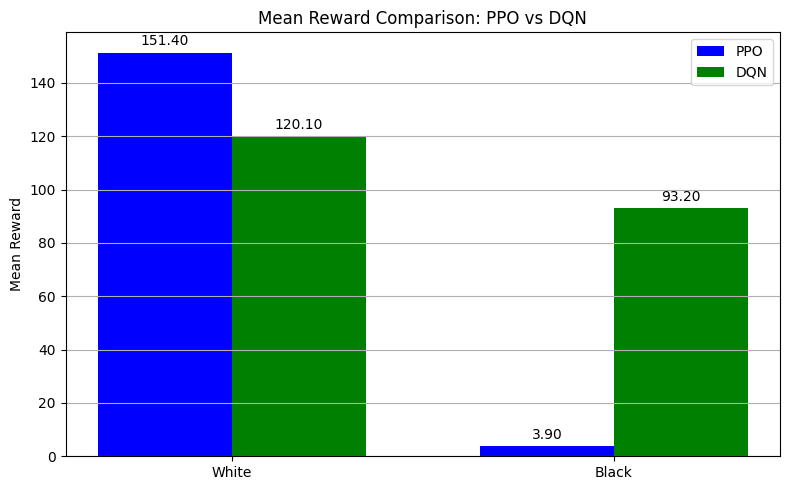

In [ ]:
import matplotlib.pyplot as plt

agents = ["w", "b"]  # Changed the agent names to 'w' and 'b'
ppo_scores = [ppo_mean_rewards[agent] for agent in agents]
dqn_scores = [dqn_mean_rewards[agent] for agent in agents]

x = np.arange(len(agents))  # label locations
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, ppo_scores, width, label='PPO', color='blue')
rects2 = ax.bar(x + width/2, dqn_scores, width, label='DQN', color='green')

# Labels and titles
ax.set_ylabel('Mean Reward')
ax.set_title('Mean Reward Comparison: PPO vs DQN')
ax.set_xticks(x)
ax.set_xticklabels(['White', 'Black'])  # Set readable labels
ax.legend()
ax.grid(axis='y')

# Annotate bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 pts vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Agent": agents,
    "PPO Reward": ppo_scores,
    "DQN Reward": dqn_scores
})

print(comparison_df.to_markdown(index=False))

| Agent   |   PPO Reward |   DQN Reward |
|:--------|-------------:|-------------:|
| w       |        151.4 |        120.1 |
| b       |          3.9 |         93.2 |
